## ニューラルネットワーク  
隠れ層のレイヤーを１個増やしてみた

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split

np.random.seed(20160614)
tf.set_random_seed(20160614)

In [2]:
#snssns..set_styleset_sty ('whitegrid')
%matplotlib inline

pd.set_option("display.max_columns", 200) # 表示カラムの最大値
pd.set_option('display.max_rows', 200) # 表示行数の最大値
pd.set_option('display.max_colwidth', 30)
pd.set_option("display.float_format", '{:.3f}'.format) # 小数点以下の有効数字

# jupyterの幅を自動調整
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### データ読み込み

In [3]:
df = pd.read_csv('../01.data/02.train/data_2013_2017.csv', index_col=0)

In [4]:
# 学習データと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(df.iloc[:, 1:df.shape[1]], 
                                                    df['target'], 
                                                    test_size=0.3, 
                                                    random_state=100)
# TensorFlow用に変換
X_train = X_train.as_matrix()
y_train = y_train.as_matrix().reshape([len(y_train), 1])
X_valid = X_valid.as_matrix()
y_valid = y_valid.as_matrix().reshape([len(y_valid), 1])

In [5]:
# 学習データと検証データの正解含有率とレコード件数
print ('train data || Correct Data Rate : %f, Length of data: %i' % (y_train.sum()/len(y_train), len(y_train)))
print ('valid data || Correct Data Rate : %f, Length of data: %i' % (y_valid.sum()/len(y_valid), len(y_valid)))

train data || Correct Data Rate : 0.175234, Length of data: 856
valid data || Correct Data Rate : 0.185286, Length of data: 367


### パラメータ

In [7]:
# make results reproducible
seed = 3
np.random.seed(seed)
tf.set_random_seed(seed)

#  説明変数の数
NUM_VARS = X_train.shape[1]

# 学習率
LEARNING_RATE = 0.0002

# 投資判断しきい値（accuracyの算出で利用）
INVEST_THRESHOLD = 0.5

# バッチサイズ
batch_size = 100

In [8]:
# 説明変数
x = tf.placeholder(shape=[None, NUM_VARS], dtype=tf.float32)
#目的変数
y = tf.placeholder(shape=[None,1], dtype=tf.float32)

In [16]:
 # 隠れ層１のユニット数
NUM_UNITS_1 = 5
 # 隠れ層２のユニット数
NUM_UNITS_2 = 4

# バイアスの初期値に利用する
mult = X_train.flatten().mean() 

# 隠れ層１を定義
w1 = tf.Variable(tf.truncated_normal([NUM_VARS, NUM_UNITS_1]))
b1 = tf.Variable(tf.zeros([NUM_UNITS_1]))
#hidden1 = tf.nn.tanh(tf.matmul(x, w1) + b1*mult)
hidden1 = tf.nn.relu(tf.matmul(x, w1) + b1*mult)

# 隠れ層2を定義
w2 = tf.Variable(tf.truncated_normal([NUM_UNITS_1, NUM_UNITS_2]))
b2 = tf.Variable(tf.zeros([NUM_UNITS_2]))
#hidden2 = tf.nn.tanh(tf.matmul(hidden1, w2) + b2*mult)
hidden2 = tf.nn.relu(tf.matmul(hidden1, w2) + b2*mult)

# 出力層を定義
w0 = tf.Variable(tf.zeros([NUM_UNITS_2, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden2, w0) + b0*mult)

**[SNE-05]** 誤差関数 loss、トレーニングアルゴリズム train_step、正解率 accuracy を定義します。

In [17]:
# 誤差関数  クロスエントロピー
loss = -tf.reduce_sum(y*tf.log(p) + (1-y)*tf.log(1-p))
# トレーニングアルゴリズム
train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)
# 正解率
correct_prediction = tf.equal(tf.sign(p-INVEST_THRESHOLD), tf.sign(y-INVEST_THRESHOLD))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 学習

In [18]:
sess = tf.Session()

In [19]:
# 変数の初期化
init = tf.global_variables_initializer()
sess.run(init)

saver = tf.train.Saver()

#cwd = os.getcwd() # Windowsのときに必要

i = 0
loss_vec_train = []
loss_vec_valid = []
acc_vec_train = []
acc_vec_valid = []

for _ in range(10000):
    i += 1
    
    batch_index = np.random.choice(len(X_train),  size=batch_size)
    random_X_train = X_train[batch_index]
    random_y_train = y_train[batch_index]
    
    sess.run(train_step, feed_dict={x: random_X_train, y: random_y_train})

    if i % 10 == 0:
        #　トレーニングセットの損失値を保存
        loss_val, acc_val  = sess.run( [loss, accuracy], feed_dict={x: random_X_train, y: random_y_train})
        
        loss_vec_train.append(loss_val / len(random_y_train))   
        acc_vec_train.append(acc_val)
        
        # テストセットの損失値を保存
        loss_val, acc_val = sess.run( [loss, accuracy],  feed_dict={x: X_valid, y: y_valid})
        
        loss_vec_valid.append(loss_val / len(y_valid))
        acc_vec_valid.append(acc_val)

    if i % 100 == 0:
        loss_val_train, acc_val_train = sess.run( [loss, accuracy], feed_dict={x: random_X_train, y: random_y_train})
        loss_val_valid, acc_val_valid = sess.run( [loss, accuracy], feed_dict={x: X_valid, y: y_valid})
        
        print ('step: %d, train loss: %f,  train accuracy: %f,  , valid loss: %f, valid accuracy: %f' % (i, 
                                                                                                         loss_val_train / len(random_y_train), 
                                                                                                         acc_val_train, 
                                                                                                         loss_val_valid / len(y_valid), 
                                                                                                         acc_val_valid))
    
saver.save(sess, './01.saved_model/model.ckpt')

step: 100, train loss: 0.452100,  train accuracy: 0.840000,  , valid loss: 0.486791, valid accuracy: 0.814714
step: 200, train loss: 0.409085,  train accuracy: 0.860000,  , valid loss: 0.487317, valid accuracy: 0.814714
step: 300, train loss: 0.508880,  train accuracy: 0.790000,  , valid loss: 0.488642, valid accuracy: 0.814714
step: 400, train loss: 0.584100,  train accuracy: 0.750000,  , valid loss: 0.484359, valid accuracy: 0.814714
step: 500, train loss: 0.450548,  train accuracy: 0.850000,  , valid loss: 0.486432, valid accuracy: 0.814714
step: 600, train loss: 0.485125,  train accuracy: 0.800000,  , valid loss: 0.484119, valid accuracy: 0.814714
step: 700, train loss: 0.451800,  train accuracy: 0.820000,  , valid loss: 0.487890, valid accuracy: 0.814714
step: 800, train loss: 0.514641,  train accuracy: 0.800000,  , valid loss: 0.483742, valid accuracy: 0.814714
step: 900, train loss: 0.356128,  train accuracy: 0.890000,  , valid loss: 0.486112, valid accuracy: 0.814714
step: 1000

step: 7500, train loss: 0.447257,  train accuracy: 0.830000,  , valid loss: 0.481167, valid accuracy: 0.814714
step: 7600, train loss: 0.393048,  train accuracy: 0.860000,  , valid loss: 0.481977, valid accuracy: 0.814714
step: 7700, train loss: 0.425414,  train accuracy: 0.840000,  , valid loss: 0.481870, valid accuracy: 0.814714
step: 7800, train loss: 0.372865,  train accuracy: 0.880000,  , valid loss: 0.480572, valid accuracy: 0.814714
step: 7900, train loss: 0.494538,  train accuracy: 0.810000,  , valid loss: 0.479881, valid accuracy: 0.814714
step: 8000, train loss: 0.518897,  train accuracy: 0.780000,  , valid loss: 0.478822, valid accuracy: 0.814714
step: 8100, train loss: 0.524709,  train accuracy: 0.790000,  , valid loss: 0.478864, valid accuracy: 0.814714
step: 8200, train loss: 0.425570,  train accuracy: 0.850000,  , valid loss: 0.479125, valid accuracy: 0.814714
step: 8300, train loss: 0.490028,  train accuracy: 0.810000,  , valid loss: 0.478721, valid accuracy: 0.814714
s

'./01.saved_model/model.ckpt'

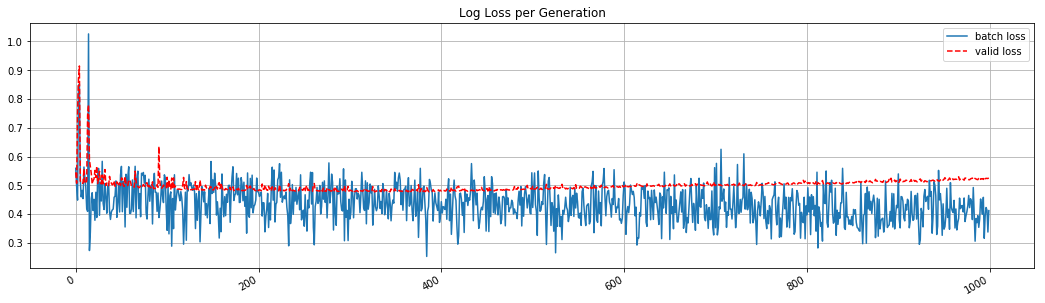

In [13]:
fig = plt.figure(figsize=(18, 5))
ax = plt.subplot()

plt.plot(loss_vec_train,   label='batch loss')
plt.plot(loss_vec_valid,  'r--',  label='valid loss' )
plt.title('Log Loss per Generation')

ax.grid() #グリッド表示
fig.autofmt_xdate() #x軸のオートフォーマット
plt.legend() # 凡例の表示
#plt.savefig('ssss.png')
plt.show()

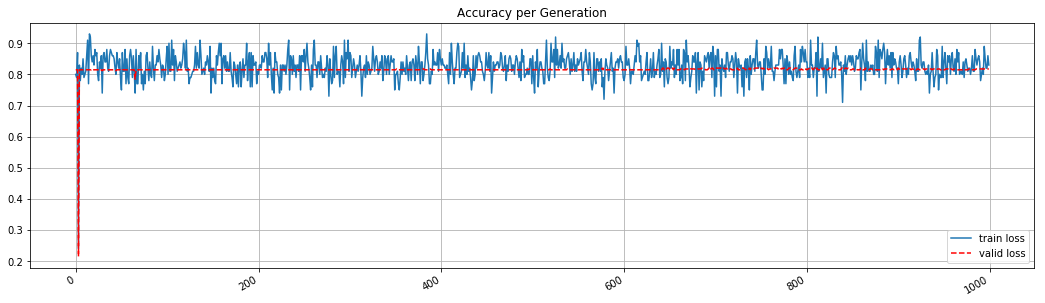

In [14]:
fig = plt.figure(figsize=(18, 5))
ax = plt.subplot()

plt.plot(acc_vec_train,   label='train loss')
plt.plot(acc_vec_valid,  'r--',  label='valid loss' )
plt.title('Accuracy per Generation')

ax.grid() #グリッド表示
fig.autofmt_xdate() #x軸のオートフォーマット
plt.legend() # 凡例の表示
#plt.savefig('ssss.png')
plt.show()

In [15]:
sess.run( p, feed_dict={x: X_valid, y: y_valid})

array([[  1.45543545e-01],
       [  2.65906721e-01],
       [  7.90299624e-02],
       [  1.69611804e-03],
       [  4.77148145e-01],
       [  2.75266647e-01],
       [  7.79008791e-02],
       [  8.68320167e-02],
       [  2.02228487e-01],
       [  7.07714111e-02],
       [  4.08726633e-01],
       [  2.18399599e-01],
       [  3.25112760e-01],
       [  2.29705513e-01],
       [  2.21909389e-01],
       [  9.95068029e-02],
       [  1.03083208e-01],
       [  9.93293077e-02],
       [  6.88261688e-02],
       [  1.78958282e-01],
       [  2.57222027e-01],
       [  3.15507948e-01],
       [  1.70454711e-01],
       [  7.98099339e-02],
       [  1.65787041e-01],
       [  2.02536911e-01],
       [  1.67302310e-01],
       [  1.04483657e-01],
       [  1.68456808e-01],
       [  1.50417686e-01],
       [  2.88019896e-01],
       [  1.24114908e-01],
       [  1.92193121e-01],
       [  1.20946310e-01],
       [  1.92980692e-01],
       [  1.63613097e-03],
       [  8.56347382e-02],
 